# Introduction:
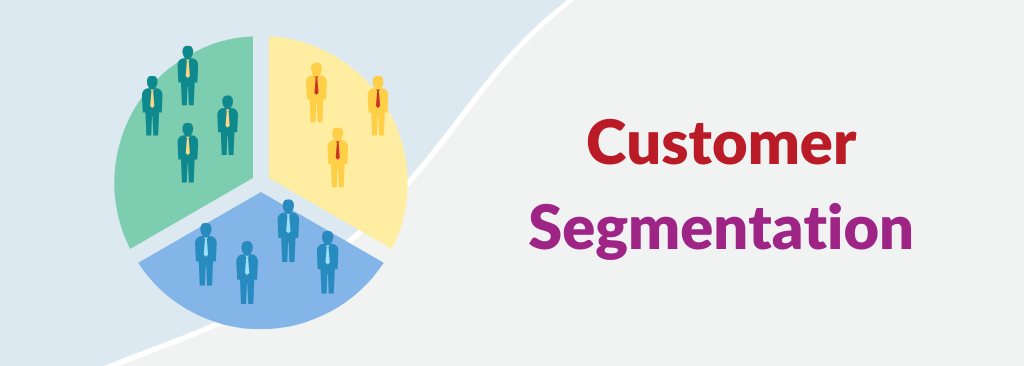

In this notebook, I will analyze and explore the purchase orders of customers from grocery stores to help the marketing department:
- Set their marketing goals.
- Identify the persons of the customer and target audiences.
- Get the best knowledge of their customer groups and behaviors.


**Let us begin by defining exactly what customer analysis is:**

The process of analyzing customer data to get insights into their behavior, preferences, and attributes is known as "customer analysis." The goal of customer analysis is to better understand customers and use this knowledge to boost customer pleasure, revenue, and loyalty.

**What exactly is customer segmentation?**

The technique of breaking customers into groups based on shared qualities or behaviors is known as "customer segmentation." Customer segmentation is to improve marketing targeting and personalize products or services for particular customer segments. Customer segmentation can include several elements, including demographics, geography, purchasing behavior, and psychographic characteristics.

Businesses may obtain a better knowledge of their consumers and build more effective strategies to fulfill their wants and preferences by combining customer analysis with customer segmentation. Customer segmentation enables firms to identify the most important customer groups and customize marketing efforts to those groups, while customer analysis gives insights into those customers' behavior and preferences.

# Main Questions:
These are the questions the marketing department wants answers to:
- What is the best segmentation for customers?
- What is the order status of different customer segments?
- What are the trends in the customer behavior segments over time?
- What are the insights from the RFM analysis?
- What are the best features for clustering the customers?

# Main Goal :
- Increase customer loyalty and customer lifetime value. 
- Remarketing to groups that haven't bought anything or haven't bought in a long time.
- Increase new customer awareness and attraction.
- Establish relationships with customers who are in the conversion stage of the marketing funnel.


# Data collection:
We have data about the customers' purchase orders over time. So we will rely on the purchase history of each customer to get actionable insights.

### Data Set Information: 
The dataset has 38765 rows of purchase orders from customers at grocery stores. These orders can be analyzed using descriptive statistics, inference statistics, RFM analysis, and machine learning algorithms such as clustering (K-means).

### Features Information:
- Member Number: Nominal, a 4-digit integral number uniquely assigned to each member. 
- Item Description: Product name (Nominal).
- Date: the day and time at which each transaction was generated.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data
groceries_data = pd.read_csv('Groceries_dataset.csv')

#displays the first 5 rows of the groceries_data
groceries_data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


# Data Understanding and Preparation:
Before I apply customer segmentation, I will explore the data, prepare it and understand it through:
- Check the data type.
- Check the missing values.
- Check the duplicate rows.
- Descriptive statistics (statistical exploration).
- Features extraction using the time factor.
- Distribution analysis.
- Grouping.
- RFM analysis.
- Correlation analysis.
- ANOVA.
- Transformation of variables (Normalization and Logarithmic transformation).
- PCA.
- Feature selection.


### Data types and missing values

In [3]:
# check the data type of each feature and the missing values
groceries_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


- The Date column is an object type, I will convert it to date type for further analysis.
- The Member_number column is int type, I will convert it to object. 
- The itemDescription have the right data type.
- I will rename the itemDescription feature for simplicity.
- We can see that the data have 38765 transactions, all of them have no null values. 

In [4]:
#convert a date column to a date type
groceries_data['Date'] = pd.to_datetime(groceries_data['Date'], format='%d-%m-%Y')
groceries_data['Member_number'] = groceries_data['Member_number'].astype(str)
groceries_data.head()

,Member_number,Date,itemDescription
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


In [5]:
# rename the itemDescription feature
groceries_data.rename(columns={'itemDescription':'item'}, inplace=True)
groceries_data.head()

,Member_number,Date,item
0,1808,2015-07-21,tropical fruit
1,2552,2015-01-05,whole milk
2,2300,2015-09-19,pip fruit
3,1187,2015-12-12,other vegetables
4,3037,2015-02-01,whole milk


### Duplicate rows 

In [6]:
# check the duplicate rows 
print("duplicate rows:",groceries_data.duplicated().sum())
print("total rows:",groceries_data.shape[0]) #shape of the data

duplicate rows: 759
total rows: 38765


There are 759 rows that are duplicated, I will remove them.

In [7]:
# drop duplicate rows 
groceries_data.drop_duplicates(inplace=True)
print("total rows after drop the duplicates:",groceries_data.shape[0])

total rows after drop the duplicates: 38006


### Descriptive statistics

In [8]:
#descriptive statistics (statistical exploration).
groceries_data.describe(include='all')

,Member_number,Date,item
count,38006,38006,38006
unique,3898,728,167
top,3180,2015-01-21 00:00:00,whole milk
freq,35,96,2363
first,NaN,2014-01-01 00:00:00,NaN
last,NaN,2015-12-30 00:00:00,NaN


These descriptive statistics show the number of unique values and the frequency of the most common values in each column of the dataset. Here are some insights we can gather from this summary:

- There are 3,898 unique customers in the dataset, and the most active customer is 3180, which made 35 transactions.
- The dataset contains transactions that occurred between January 1, 2014, and December 30, 2015.
- The 'Date' column contains 728 unique dates, with the most common date that has many purchases being January 21, 2015, which appears 96 times.
- The 'item' column contains 167 unique items, with the most purchased item being 'whole milk', which appears 2,363 times.

We can use the power of visualization to get more insights about the customers' orders and the most ordered items.

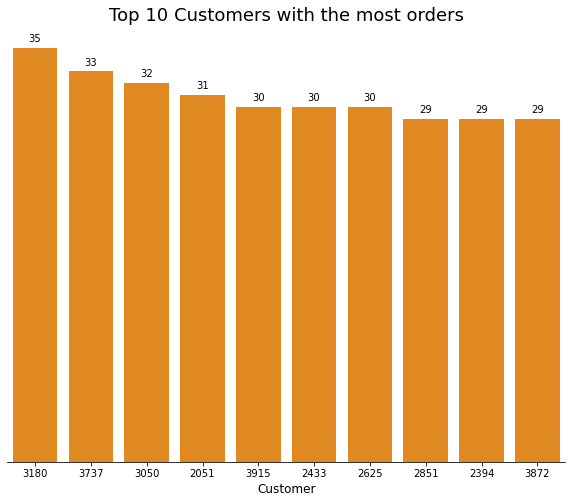

In [9]:
# Get the top 10 customers with the most orders
top_customers = groceries_data['Member_number'].value_counts().nlargest(10)

# Create a bar plot of the number of orders for each of the top 10 customers
plt.figure(figsize=(10,8))
sns.barplot(x=top_customers.index, y=top_customers.values,color= 'darkorange')

# Remove the y-axis and y-axis values
sns.despine(left=True)
plt.yticks([])

# Add labels to the bars
for index, value in enumerate(top_customers.values):
    plt.text(index, value + 0.5, str(value), ha='center')

# Set the title, x-label, and rotation of the x-tick labels
plt.title('Top 10 Customers with the most orders',size = 18)
plt.xlabel('Customer',size = 12)
plt.xticks()

# Display the plot
plt.show()

We can see that customer 3180 is at the top with 35 orders, then customer 3737 with 33, then other top customers vary from a range of 35 to 29 orders through the 2 years.

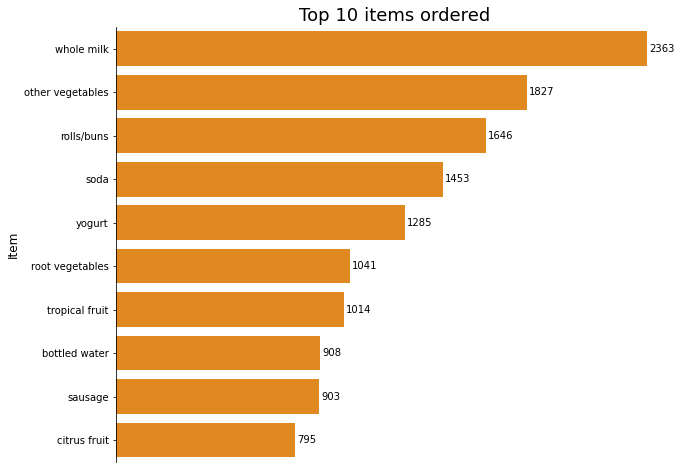

In [10]:
# Get the top 10 items that were ordered the most
top_items = groceries_data['item'].value_counts().nlargest(10)

# Create a bar plot of the number of times each of the top 10 items was ordered
plt.figure(figsize=(10,8))
sns.barplot(y=top_items.index, x=top_items.values,color= 'darkorange', orient='h')

# Remove the x-axis and x-axis values
sns.despine(bottom=True)
plt.xticks([])

# Add labels to the bars
for index, value in enumerate(top_items.values):
    plt.text(value + 10, index, str(value), ha='left', va='center')

# Set the title, x-label, and rotation of the x-tick labels
plt.title('Top 10 items ordered',size = 18)
plt.ylabel('Item',size = 12)
plt.yticks()

# Display the plot
plt.show()

We can see that whole milk is the most sold item with 2363 times, then other vegetable categories by 1827 times. The other top items range from 1650 to 800 times.

### Features extraction:
For deeper analysis and machine learning techniques, we should extract more features from the original to help us understand more about customers' orders and find patterns. I will use these to check the correlation between them and RFM metrics and segment the customers based on them using K-means.

I will extract from the date column: the year, month, day of the year, day of the month, and day of the week features.

In [11]:
#Copy the orignal data
groceries_data_original = groceries_data.copy()

# Extract year component from 'Date' column and create a new 'Year' column
groceries_data['Year'] = groceries_data['Date'].dt.year

# Extract month component from 'Date' column and create a new 'Month' column
groceries_data['Month'] = groceries_data['Date'].dt.month

# Extract day of the year component from 'Date' column and create a new 'DayOfYear' column
groceries_data['DayOfYear'] = groceries_data['Date'].dt.dayofyear

# Extract day of the month component from 'Date' column and create a new 'DayOfMonth' column
groceries_data['DayOfMonth'] = groceries_data['Date'].dt.day

# Extract day of the week component from 'Date' column and create a new 'DayOfWeek' column
groceries_data['DayOfWeek'] = groceries_data['Date'].dt.dayofweek

#view the data after features extraction step
groceries_data.head()

,Member_number,Date,item,Year,Month,DayOfYear,DayOfMonth,DayOfWeek
0,1808,2015-07-21,tropical fruit,2015,7,202,21,1
1,2552,2015-01-05,whole milk,2015,1,5,5,0
2,2300,2015-09-19,pip fruit,2015,9,262,19,5
3,1187,2015-12-12,other vegetables,2015,12,346,12,5
4,3037,2015-02-01,whole milk,2015,2,32,1,6


### Distribution analysis:
We can use the histogram to understand the distribution of the new features.

In [12]:
# select the numerical columns
numerical_columns = groceries_data.select_dtypes(include='number').columns.tolist()
numerical_columns

['Year', 'Month', 'DayOfYear', 'DayOfMonth', 'DayOfWeek']

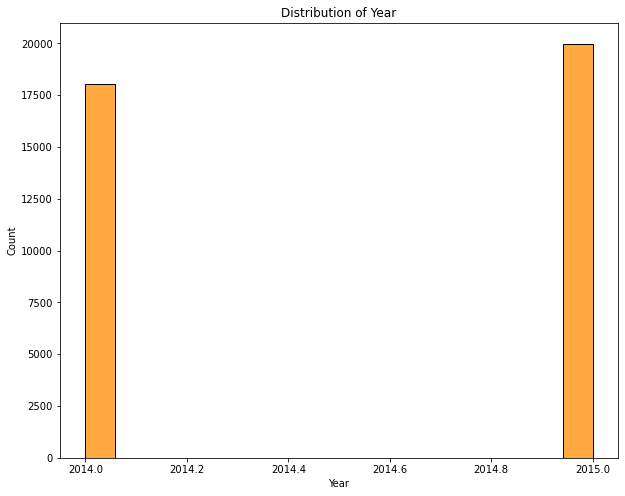

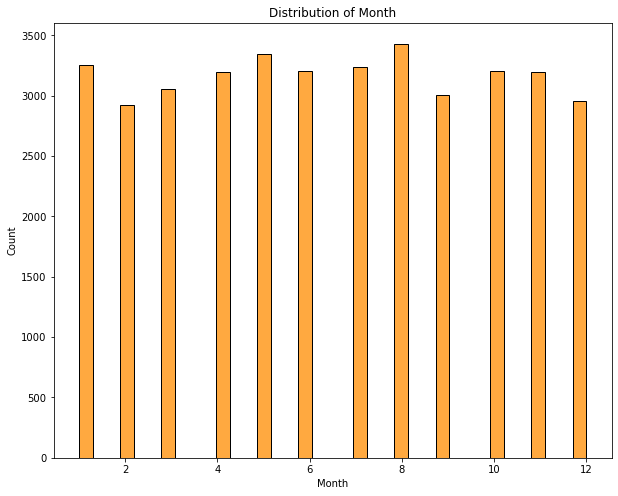

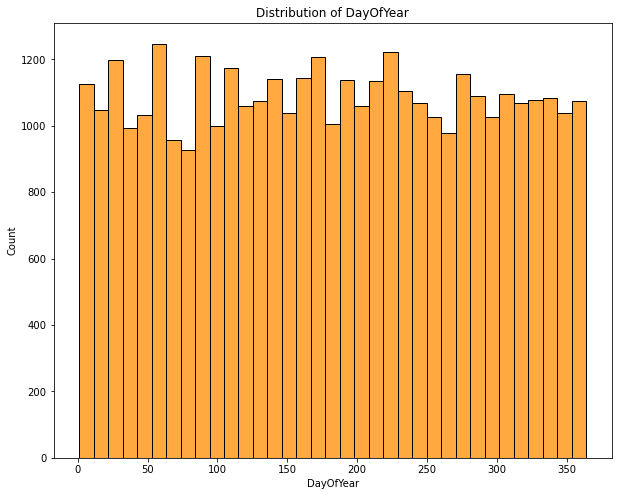

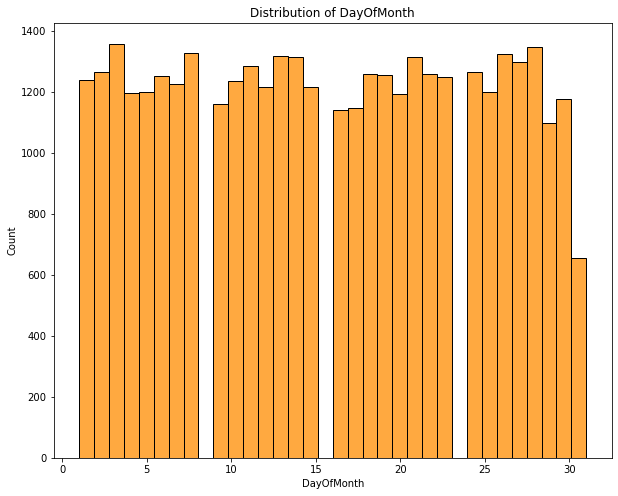

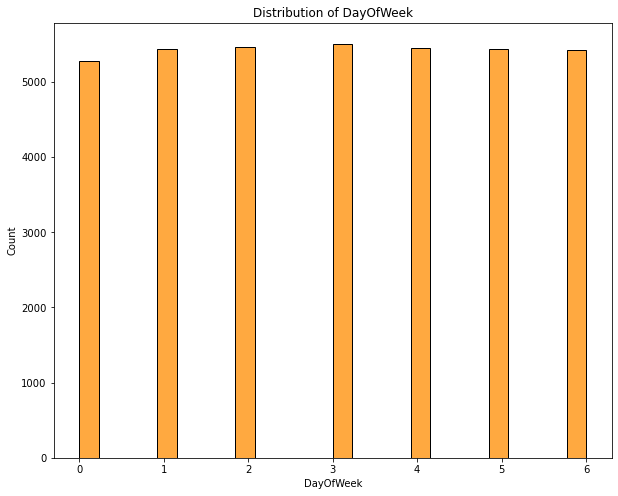

In [13]:
# Check the distribution of each column
for column in numerical_columns:
    plt.figure(figsize=(10,8))
    sns.histplot(groceries_data[column],color='darkorange').set(title=f'Distribution of {column}', xlabel=column);

- We can observe that 2015 has higher orders than 2014.
- We see also increasing in the orders as we move from the winter to the summer then the orders curve decreases when going to the start of the winter. But in January, May and August we have higher orders.
- The distribution of the day of the year show also that there is increasing in orders from the conversion of the winter to the summer then the orders curve decreased when going to the start of the winter.
- The distribution of the day of the month and the day of the week show that there is increasing in orders in the middle of the week.

### Grouping:
We now need to group the data by each customer and select the most frequent value of each column of the extracted features to represent him.
For example, I will get the most frequent year, most frequent month, most frequent day of the year, most frequent day of the month, and most frequent day of the week on which the customer made an order on it.
I want to include the time factor of the customer transactions to find patterns in the customer order time. Does he make an order based on a particular day in the week or based on a particular day of the month?

It is useful for analyzing the purchasing patterns of individual customers over time, and identifying any trends or patterns in their shopping behavior. By calculating the mode of each time-related column, it can help identify the most common day, week, month, or year that a customer makes purchases, which could be useful for targeted marketing or promotions in the future.

In [14]:
# Group the data by each customer
customer_transactions_time = groceries_data.groupby('Member_number').agg({
    'Year': lambda x: list(x.mode()),        # Calculate mode of Year column for each customer
    'Month': lambda x: list(x.mode()),       # Calculate mode of Month column for each customer
    'DayOfYear': lambda x: list(x.mode()),   # Calculate mode of DayOfYear column for each customer
    'DayOfMonth': lambda x: list(x.mode()),  # Calculate mode of DayOfMonth column for each customer
    'DayOfWeek': lambda x: list(x.mode())    # Calculate mode of DayOfWeek column for each customer
})

# Display the resulting dataframe to preview the first few rows
customer_transactions_time.head()

,Year,Month,DayOfYear,DayOfMonth,DayOfWeek
Member_number,,,,,
1000,[2015],[3],[74],[24],"[2, 6]"
1001,[2015],"[1, 2]","[20, 38]","[7, 20]","[1, 4]"
1002,"[2014, 2015]",[4],[116],[26],[6]
1003,[2014],[2],"[19, 41, 288]","[10, 15, 19]","[1, 2, 6]"
1004,[2014],"[7, 10]",[286],[10],[1]


In [15]:
# Apply max() to each element of the DataFrame
customer_transactions_time = customer_transactions_time.applymap(max)
customer_transactions_time

,Year,Month,DayOfYear,DayOfMonth,DayOfWeek
Member_number,,,,,
1000,2015,3,74,24,6
1001,2015,2,38,20,4
1002,2015,4,116,26,6
1003,2014,2,288,19,6
1004,2014,10,286,10,1
...,...,...,...,...,...
4996,2015,11,328,24,1
4997,2015,12,361,27,6
4998,2015,10,287,14,2


In [16]:
customer_transactions_time.shape

(3898, 5)

I selected the most frequent value for each column, if the user has multiple most frequent values in each column, I will select the recent one.

### RFM analysis
These features which I extracted aren't enough to find the best segmentation and understand the customer better. I will perform RFM analysis to assign recency, frequency, and monetary values to each member.


First, I will explain What is RFM? and What are RFM metrics?

RFM stands for Recency, Frequency, and Monetary Value, which are three key metrics used in customer segmentation and customer relationship management (CRM). The RFM analysis is a technique used to segment customers based on these three metrics, with the goal of identifying high-value customers, understanding customer behavior, and tailoring marketing and sales strategies to different customer segments.

The three components of RFM are:

- Recency: The time elapsed since the last time a customer made a purchase in days. Customers who have made a purchase more recently are generally more valuable than those who have not made a purchase in a long time.

- Frequency: The number of times a customer has made a purchase. Customers who make frequent purchases are generally more valuable than those who make infrequent purchases.

- Monetary value: The amount of money a customer has spent on purchases. Customers who have spent more money are generally more valuable than those who have spent less money. Because our data didn't have the amount of money for each transaction, I will estimate the monetary value for each customer using the number of unique products purchased by the customer.


After RFM analysis I will do correlation analysis and K-means clustering. For example, I could segment customers into groups such as:

- High-value customers who have made a recent purchase and spent a lot of money
- Loyal customers who make frequent purchases but may not spend as much money
- Dormant customers who haven't made a purchase in a long time

By segmenting customers in this way, I can tailor the marketing and sales strategies to each group to maximize customer retention, increase customer lifetime value, and improve overall business performance.

In [17]:
#Calculate the recency metric for each customer
recency = groceries_data_original.groupby('Member_number')['Date'].max().reset_index()
recency['Recency'] = (pd.to_datetime('2015-12-30') - recency['Date']).dt.days
recency = recency[['Member_number', 'Recency']]

# Calculate the frequency metric for each customer
frequency = groceries_data_original.groupby('Member_number')['item'].count().reset_index()
frequency.rename(columns={'item': 'Frequency'}, inplace=True)

# Calculate the monetary metric for each customer
monetary = groceries_data_original.groupby('Member_number')['item'].nunique().reset_index()
monetary.rename(columns={'item': 'Monetary'}, inplace=True)

In [18]:
# Merge the recency, frequency, and monetary metrics into a single DataFrame
RFM_data = pd.merge(recency, frequency, on='Member_number')
RFM_data = pd.merge(RFM_data, monetary, on='Member_number')
RFM_data.head()

,Member_number,Recency,Frequency,Monetary
0,1000,35,13,11
1,1001,242,12,9
2,1002,122,8,8
3,1003,323,7,6
4,1004,28,21,16


After we have created two datasets with many new features, we can merge them to have all the extracted features for correlation analysis and K-means clustering.

In [19]:
# Merge the two DataFrames based on the 'Member_number' column
merged_df = pd.merge(customer_transactions_time, RFM_data, on='Member_number')
merged_df.head()

,Member_number,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,Recency,Frequency,Monetary
0,1000,2015,3,74,24,6,35,13,11
1,1001,2015,2,38,20,4,242,12,9
2,1002,2015,4,116,26,6,122,8,8
3,1003,2014,2,288,19,6,323,7,6
4,1004,2014,10,286,10,1,28,21,16


In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3898 entries, 0 to 3897
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Member_number  3898 non-null   object
 1   Year           3898 non-null   int64 
 2   Month          3898 non-null   int64 
 3   DayOfYear      3898 non-null   int64 
 4   DayOfMonth     3898 non-null   int64 
 5   DayOfWeek      3898 non-null   int64 
 6   Recency        3898 non-null   int64 
 7   Frequency      3898 non-null   int64 
 8   Monetary       3898 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 304.5+ KB


In [21]:
# Change the index to be customer id
merged_df.set_index('Member_number',inplace= True)
merged_df.head()

,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,Recency,Frequency,Monetary
Member_number,,,,,,,,
1000,2015,3,74,24,6,35,13,11
1001,2015,2,38,20,4,242,12,9
1002,2015,4,116,26,6,122,8,8
1003,2014,2,288,19,6,323,7,6
1004,2014,10,286,10,1,28,21,16


### Correlation analysis:

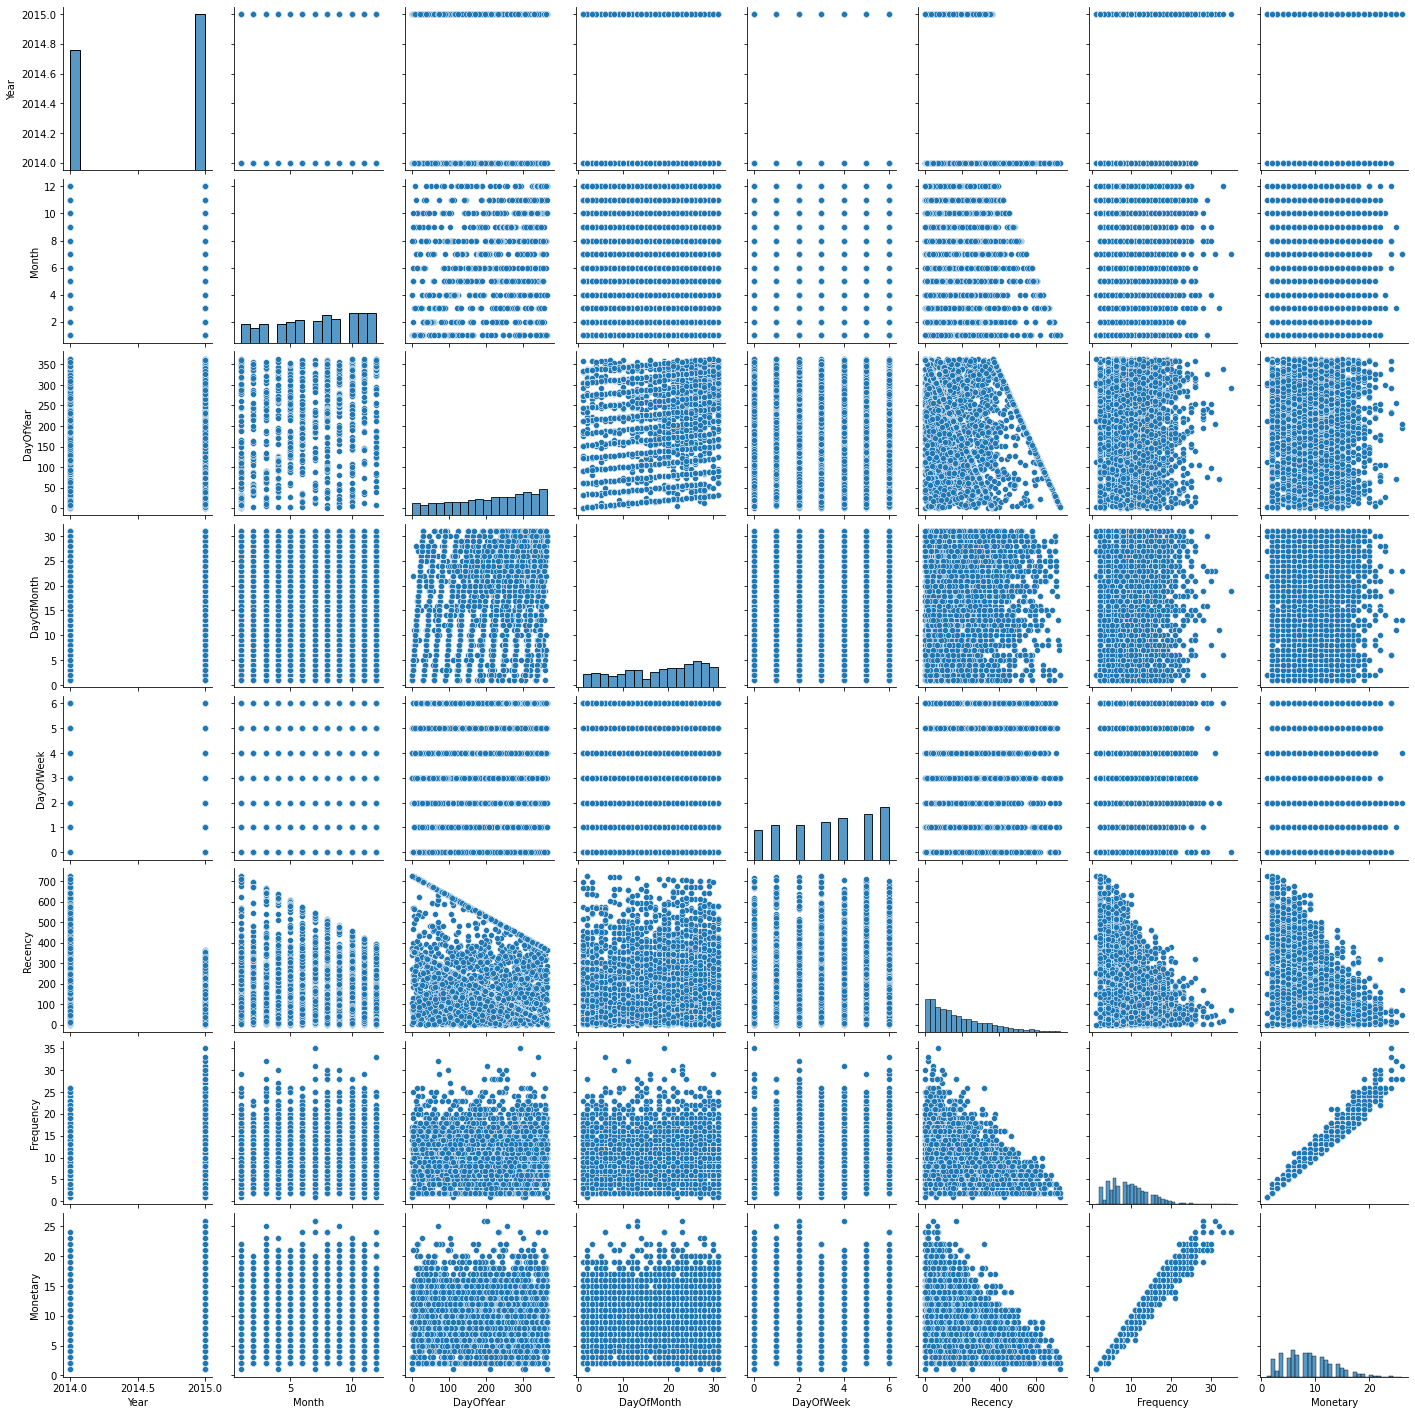

In [22]:
# scatterplot matrix
sns.pairplot(merged_df);

The scatter plot matrix shows that there is a correlation between some variables I will get the pearson's correlation matrix to check it.

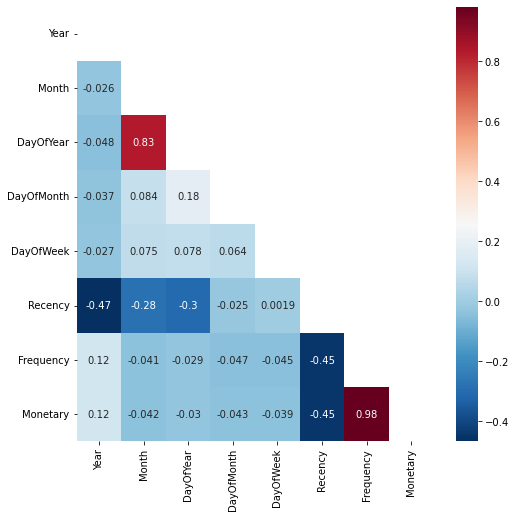

In [23]:
# Correlation matrix
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(merged_df.corr(method='pearson')))
sns.heatmap(merged_df.corr(), cmap='RdBu_r', annot=True,mask=mask);

We observe that monetary and frequency have a high positive correlation, and day of the year and Month also. Recency has a significant correlation with the majority of columns.

If the features have a high degree of correlation, it can affect the performance of clustering algorithms, as it may cause the algorithm to give more weight to certain features and produce biased results.

Highly correlated features can also introduce redundancy into the dataset, which can increase the computational complexity and decrease the interpretability of the clustering results.

Therefore, it is generally a good practice to perform feature selection or dimensionality reduction techniques, such as principal component analysis (PCA), before applying clustering algorithms to identify the most relevant and informative features.

I also will use one-way ANOVA to test the significance of the difference between the customers. This will let me know if these features discriminate the customers or not.

### ANOVA

In [24]:
# Loop over each column in the DataFrame and apply ANOVA to each group
for col in merged_df.columns:
        f_stat, p_value = f_oneway(merged_df.index,merged_df[col])
        print('{}: F-statistic = {:.2f}, p-value = {:.4f}'.format(col, f_stat, p_value))

Year: F-statistic = 2850.58, p-value = 0.0000
Month: F-statistic = 26187.31, p-value = 0.0000
DayOfYear: F-statistic = 22590.76, p-value = 0.0000
DayOfMonth: F-statistic = 25999.66, p-value = 0.0000
DayOfWeek: F-statistic = 26254.18, p-value = 0.0000
Recency: F-statistic = 22692.05, p-value = 0.0000
Frequency: F-statistic = 26141.92, p-value = 0.0000
Monetary: F-statistic = 26156.59, p-value = 0.0000


- The output shows the results of ANOVA analysis for each feature, with the F-statistic and p-value. The ANOVA results indicate that all of the features have very small p-values (p-value = 0.0000), which suggests that there is a significant difference between the groups in each feature.

- This means that the different customers in the dataset exhibit different patterns of purchasing behavior in terms of the features that have been extracted. These patterns can be used to segment the customers into different groups based on their purchasing behavior.

- We can also include that features like Recency,DayOfWeek,Frequency,Monetary, and Month are more important in discriminate the customers than other features.

### Normalization and Logarithmic transformation:

In [25]:
#Logarithmic transformation
log_data = np.log(merged_df + 0.0000000001).round(2)
log_data.head()

,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,Recency,Frequency,Monetary
Member_number,,,,,,,,
1000,7.61,1.10,4.30,3.18,1.79,3.56,2.56,2.40
1001,7.61,0.69,3.64,3.00,1.39,5.49,2.48,2.20
1002,7.61,1.39,4.75,3.26,1.79,4.80,2.08,2.08
1003,7.61,0.69,5.66,2.94,1.79,5.78,1.95,1.79
1004,7.61,2.30,5.66,2.30,0.00,3.33,3.04,2.77


In [26]:
# Normalize the data using StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(merged_df).round(2)
normalized_data = pd.DataFrame(normalized_data,columns=merged_df.columns)
normalized_data.head()

,Year,Month,DayOfYear,DayOfMonth,DayOfWeek,Recency,Frequency,Monetary
0,0.88,-1.22,-1.30,0.70,1.33,-0.96,0.63,0.47
1,0.88,-1.52,-1.64,0.24,0.32,0.34,0.43,0.02
2,0.88,-0.93,-0.89,0.93,1.33,-0.41,-0.34,-0.21
3,-1.14,-1.52,0.76,0.13,1.33,0.85,-0.53,-0.66
4,-1.14,0.83,0.74,-0.89,-1.18,-1.00,2.17,1.61


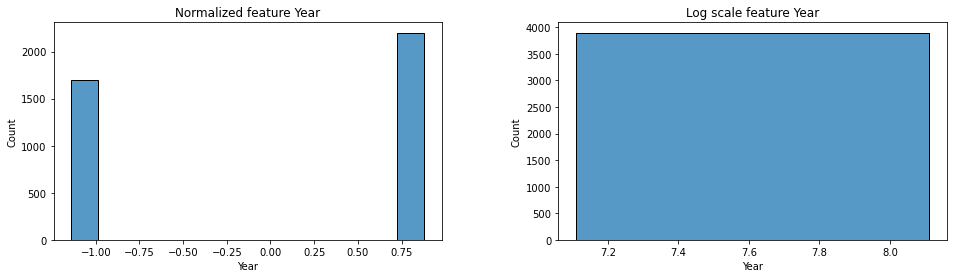

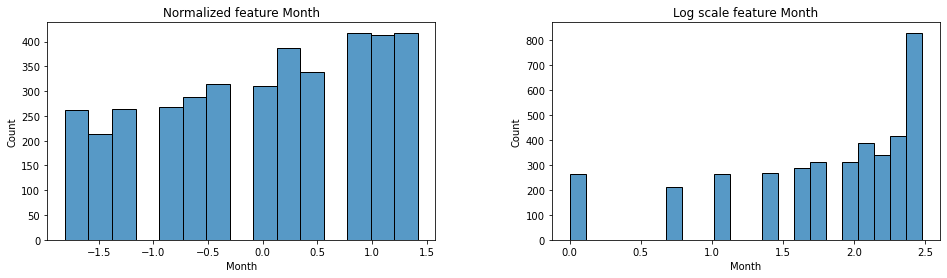

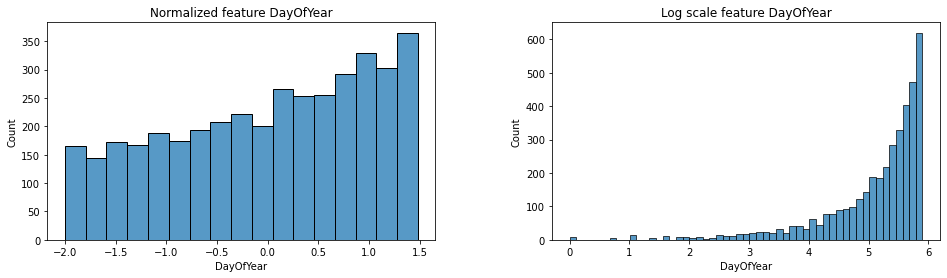

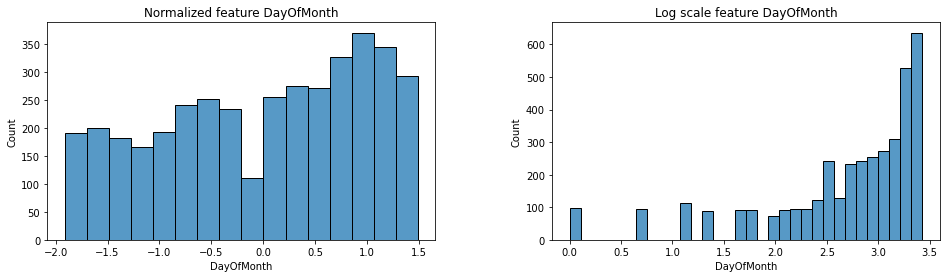

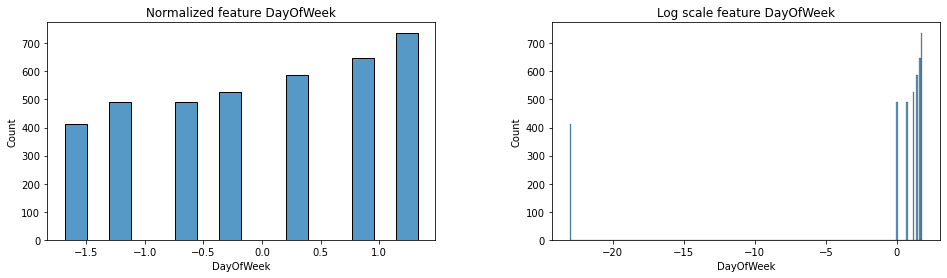

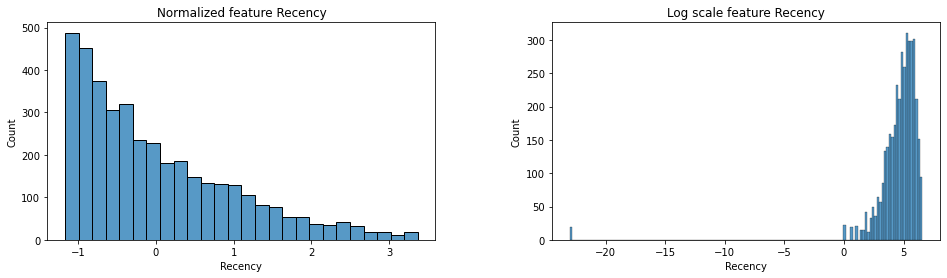

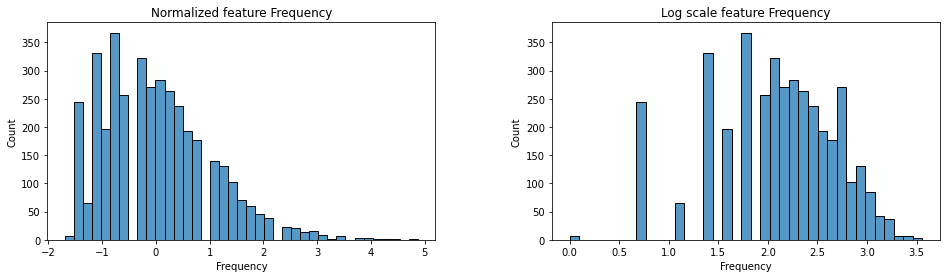

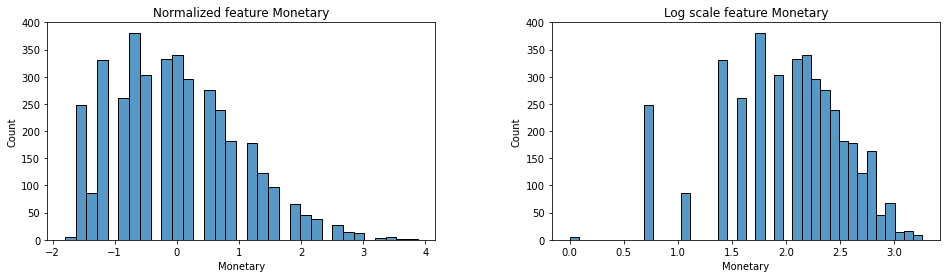

In [27]:
# Loop over each feature in the merged dataframe
for col in merged_df.columns:

    # Set the figure size
    plt.figure(figsize=(16, 4))

    # Create a subplot for the normalized feature
    plt.subplot(1, 2, 1)
    sns.histplot(normalized_data[col])
    plt.title('Normalized feature {}'.format(str(col)))

    # Create a subplot for the log-scaled feature
    plt.subplot(1, 2, 2)
    sns.histplot(log_data[col])
    plt.title('Log scale feature {}'.format(str(col)))

    # Adjust the spacing between the subplots
    plt.subplots_adjust(wspace=0.3)

    # Show the plot
    plt.show()

The log scale shows some columns have normal distribution so I will use it in PCA and will compare the two transformations in the k-means step.

### PCA:

I will apply the PCA to the log data because the standardized data doesn't make sense. Because when we center the time features around mean = zero this does not convert it to the normal distribution and will center the data around the middle part of the date features. The PCA will define the most important features that cover the most variation between the customers and the suitable value for K in K-means.

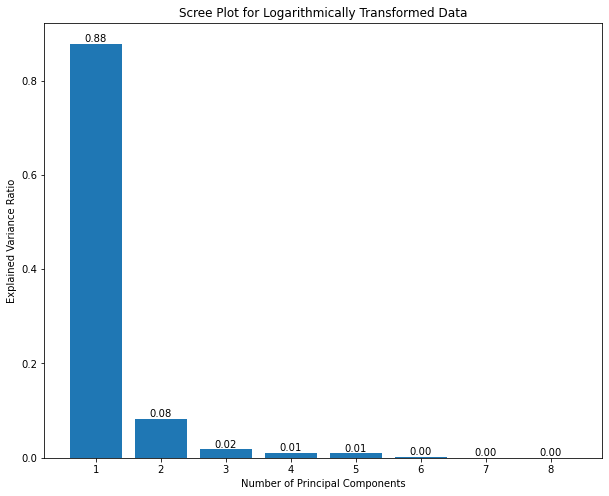

In [28]:
# Define the number of principal components to evaluate
n_components = log_data.shape[1]

# Create a PCA object with the desired number of components
pca = PCA(n_components = n_components)

# Fit the PCA model to the log_data
pca.fit(log_data)

# Plot the scree plot as a bar plot
plt.figure(figsize=(10,8))
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xticks(range(1, n_components+1))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for Logarithmically Transformed Data')

# Add labels to the bar plot
for i, ratio in enumerate(pca.explained_variance_ratio_):
    label = '{:.2f}'.format(ratio)
    plt.annotate(label, (i+1, ratio), ha='center', va='bottom')

plt.show()

We can see that the top 2 components explain 96% of the variation in the data.

In [30]:
from pca import pca
model = pca(n_components=2)

# Fit transform
out = model.fit_transform(log_data)

# Print the top features.
out['topfeat']

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [8] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,PC,feature,loading,type
0,PC1,DayOfWeek,-0.999964,best
1,PC2,Recency,-0.991762,best
2,PC1,Year,-0.000000,weak
3,PC2,Month,0.062460,weak
4,PC2,DayOfYear,0.076043,weak
5,PC2,DayOfMonth,0.014943,weak
6,PC2,Frequency,0.059191,weak
7,PC2,Monetary,0.054746,weak


The most important features that influence the creation of the new components and have the most variation between the customers are DayOfWeek and Recency.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[pca] >Plot PC1 vs PC2 with loadings.


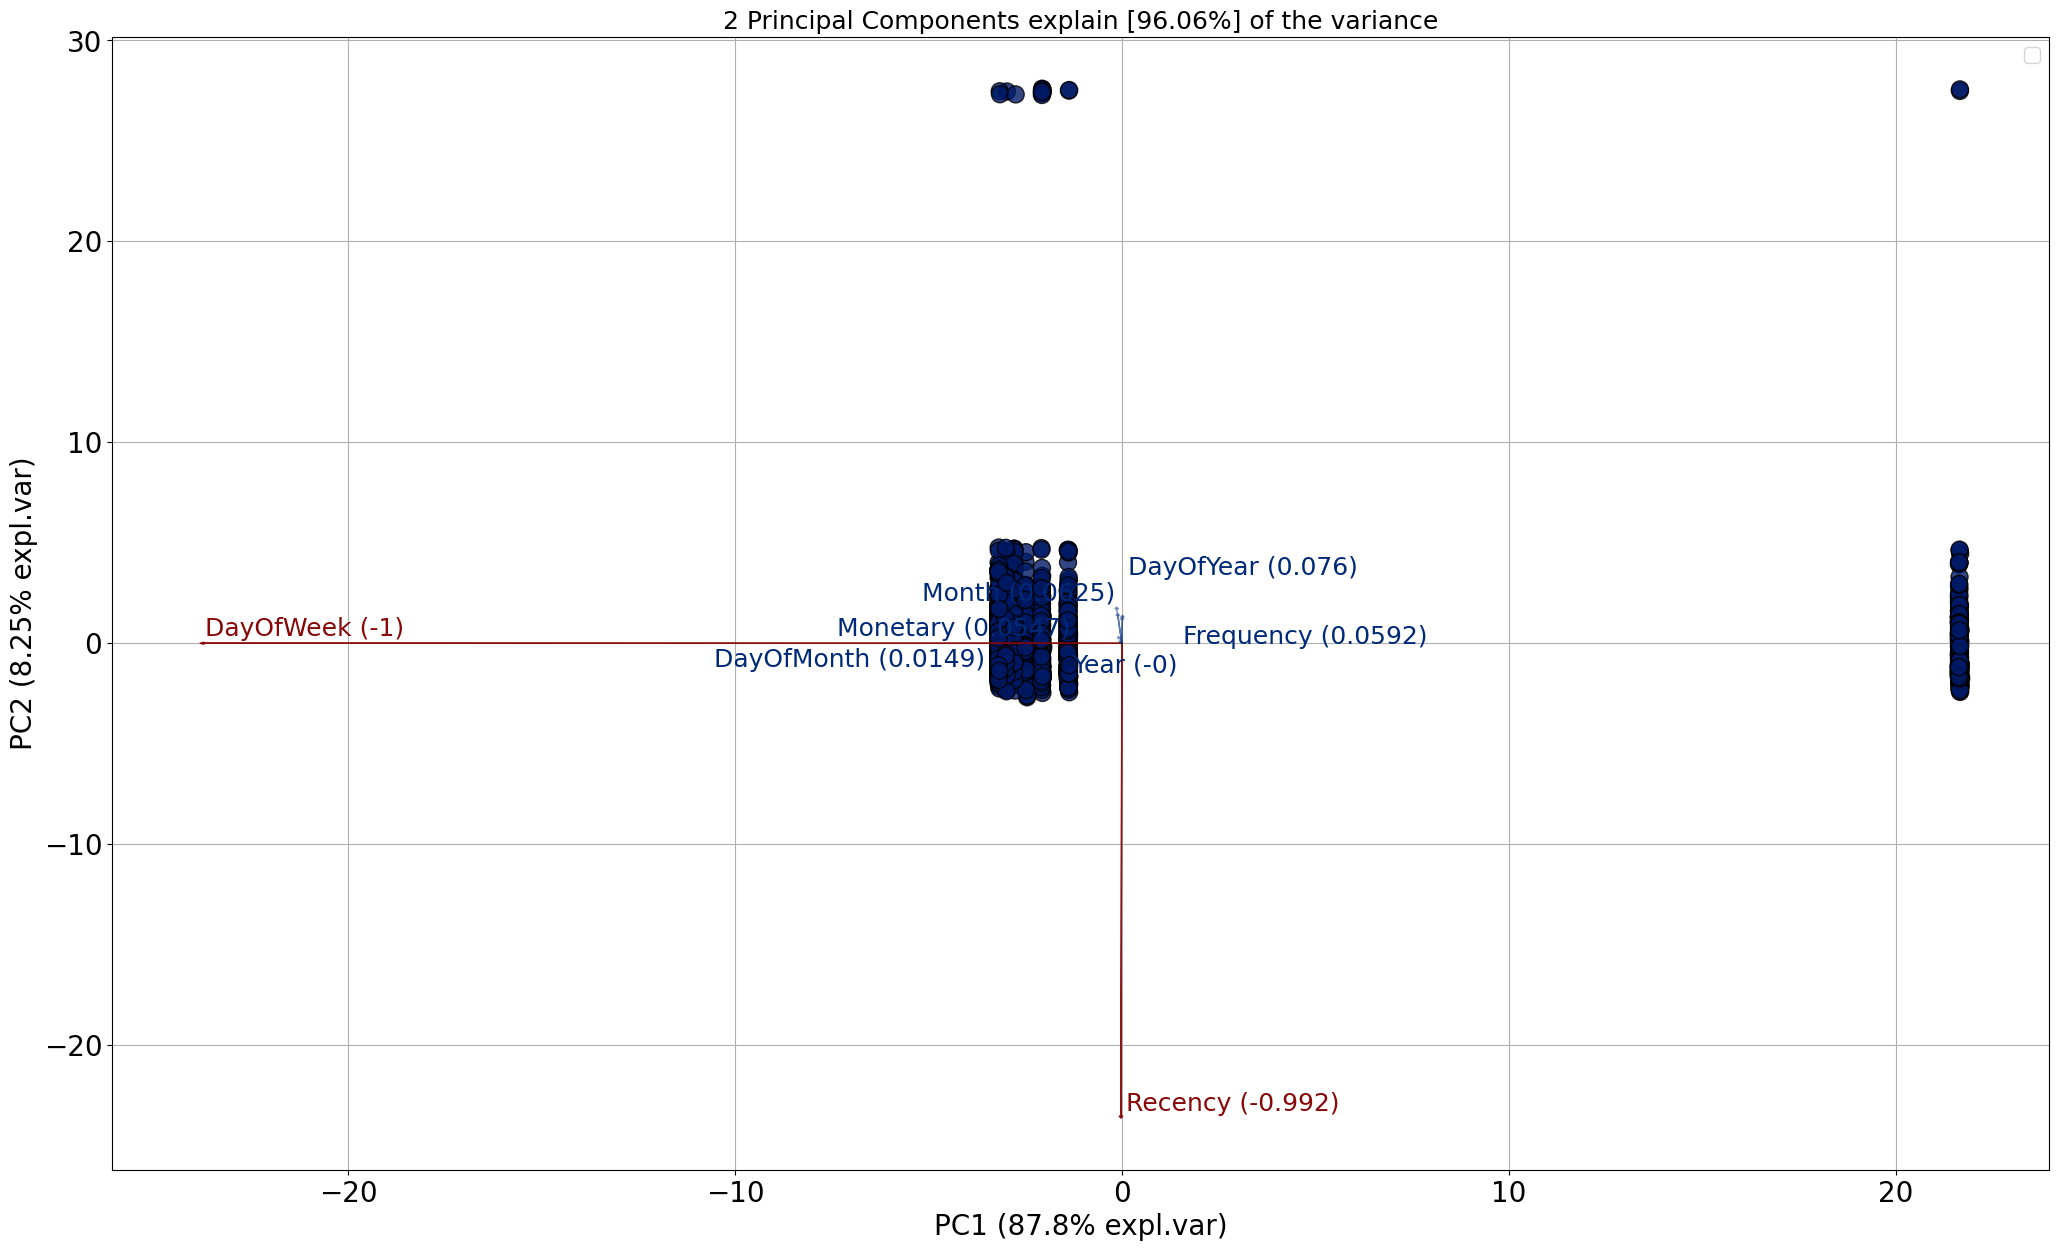

(<Figure size 2500x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'2 Principal Components explain [96.06%] of the variance'}, xlabel='PC1 (87.8% expl.var)', ylabel='PC2 (8.25% expl.var)'>)

In [31]:
model.biplot(legend=True)

- We can see that these features are good to cluster the customers but the PCA does not indicate that the other features are bad for clustering. It only defines the most important features that have the most variation in the data.
- We have also an initial indicator about the best values for K, it may be 2 or 3, or 4.

### Feature selection:

I will explore the best features for clustering through an iterative process. I will use all the important features I defined from all the last analyses and do many experiments using cluster matrics like WSS and silhouette score. 
The best subset features will be which minimize the WSS error and increase the silhouette score. The subset features should be more than one feature to discover more patterns in the customer segments.

In [32]:
model_data = merged_df.copy()
model_data = model_data[['Frequency','Monetary','DayOfWeek','Recency']]
log_data = log_data[['Frequency','Monetary','DayOfWeek','Recency']]
normalized_data = normalized_data[['Frequency','Monetary','DayOfWeek','Recency']]
model_data.head()

,Frequency,Monetary,DayOfWeek,Recency
Member_number,,,,
1000,13,11,6,35
1001,12,9,4,242
1002,8,8,6,122
1003,7,6,6,323
1004,21,16,1,28


In [33]:
# Define the set of candidate feature subsets
features = ["Frequency", "Monetary", "DayOfWeek", "Recency"]
candidate_subsets = []
for i in range(1, len(features) + 1):
    candidate_subsets += list(combinations(features, i))


# Apply K-means clustering for each feature subset and evaluate clustering performance
for subset in candidate_subsets:
    X = log_data[list(subset)].values
    kmeans = KMeans(n_clusters=2).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    wss = kmeans.inertia_
    if score > 0.9 and wss < 10000:
        # Print the best feature subset and its score
        print("Feature subset: ", subset)
        print("Silhouette score: ", score)
        print('wss score:',wss)
    

Feature subset:  ('DayOfWeek',)
Silhouette score:  0.9761219896550766
wss score: 1226.639390129126
Feature subset:  ('Recency',)
Silhouette score:  0.9525273908520548
wss score: 5585.014892343392
Feature subset:  ('Frequency', 'DayOfWeek')
Silhouette score:  0.9580567316344423
wss score: 2664.3419553430303
Feature subset:  ('Frequency', 'Recency')
Silhouette score:  0.9422451143661911
wss score: 7022.756616241293
Feature subset:  ('Monetary', 'DayOfWeek')
Silhouette score:  0.9594042891216992
wss score: 2503.1464080940464
Feature subset:  ('Monetary', 'Recency')
Silhouette score:  0.9431226864629378
wss score: 6861.491468653076
Feature subset:  ('Frequency', 'Monetary', 'DayOfWeek')
Silhouette score:  0.9491753827362386
wss score: 3940.848973307947
Feature subset:  ('Frequency', 'Monetary', 'Recency')
Silhouette score:  0.9360945732435138
wss score: 8299.233192550979


We can see that all the subsets that have the recency have a larger WSS than others so I will exclude it. So the best three features which perform optimal clusters are frequency, monetary, and DayOfWeek.

In [34]:
#optimal features
model_data = model_data[['Frequency','Monetary','DayOfWeek']]
log_data = log_data[['Frequency','Monetary','DayOfWeek']]
normalized_data = normalized_data[['Frequency','Monetary','DayOfWeek']]
model_data.head()

,Frequency,Monetary,DayOfWeek
Member_number,,,
1000,13,11,6
1001,12,9,4
1002,8,8,6
1003,7,6,6
1004,21,16,1


# K-means

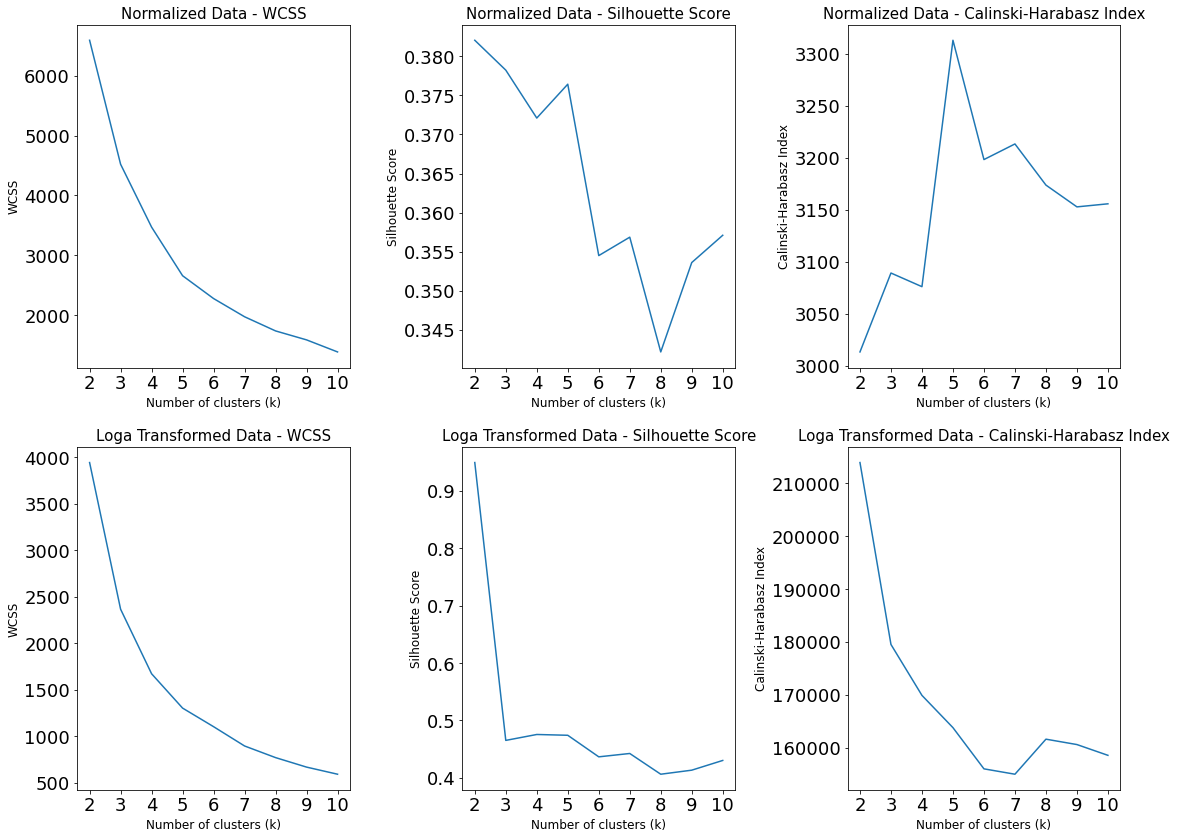

In [35]:
# Set the range of k values to evaluate
k_values = range(2, 11)

# Define the list of datasets to evaluate
data_list = [normalized_data, log_data]

# Define the list of subplot titles
title_list = ['Normalized Data', 'Loga Transformed Data']

# Define the list of metric names
metric_list = ['WCSS', 'Silhouette Score', 'Calinski-Harabasz Index']

# Create subplots for each dataset
fig, axs = plt.subplots(2, 3, figsize=(16, 12))

# Loop over each dataset and metric and plot the elbow plot
for i, data in enumerate(data_list):
    for j, metric in enumerate(metric_list):
        # Calculate the metric for each value of k
        metric_values = []
        for k in k_values:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(data)
            if metric == 'WCSS':
                metric_values.append(kmeans.inertia_)
            elif metric == 'Silhouette Score':
                labels = kmeans.labels_
                metric_values.append(silhouette_score(data, labels))
            elif metric == 'Calinski-Harabasz Index':
                labels = kmeans.labels_
                metric_values.append(calinski_harabasz_score(data, labels))

        # Plot the results as a subplot
        axs[i][j].plot(k_values, metric_values)
        axs[i][j].set_xlabel('Number of clusters (k)',size = 12)
        axs[i][j].set_xticks(range(2,11))
        axs[i][j].set_ylabel(metric,size = 12)
        axs[i][j].set_title('{} - {}'.format(title_list[i], metric),size = 15)

# Adjust spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

In [36]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(log_data)
labels = kmeans.labels_

# Compute the silhouette score
score = silhouette_score(log_data, kmeans.labels_)
score

0.4651580265965812

We can see that the logarithmically transformed data perform better clusters, and have better evaluation scores in the three plots:
- Higher silhouette score at 2 clusters approximately 0.95 very close to 1.
- Very High Calinski-Harabasz Index score at 2 clusters (210000).
- Lower WSS at 5 clusters using the elbow method, but doesn't different much than WSS for k = 3 and 4.

For the business value, we need more than 2 clusters to better understand many numbers of customers' personas. So I will trade off between a low WCSS and high silhouette score and a high High Calinski-Harabasz Index score.
So I will use K = 3.

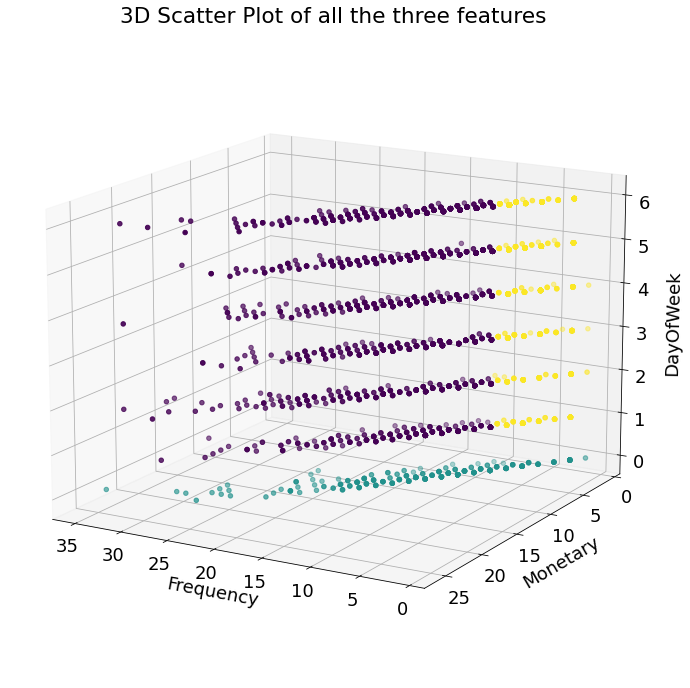

In [37]:
# Plot a 3D scatter plot of the three features
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(model_data['Frequency'], model_data['Monetary'], model_data['DayOfWeek'], c=labels)
ax.set_xlabel('Frequency', labelpad=10)
ax.set_ylabel('Monetary', labelpad=10)
ax.set_zlabel('DayOfWeek', labelpad=10)
ax.set_title('3D Scatter Plot of all the three features')

# Rotate the plot to a desired angle
ax.view_init(elev=15, azim=120)
plt.show()

## Review of Results:

In [38]:
model_data['cluster'] = labels
model_data.head()

,Frequency,Monetary,DayOfWeek,cluster
Member_number,,,,
1000,13,11,6,0
1001,12,9,4,0
1002,8,8,6,0
1003,7,6,6,2
1004,21,16,1,0


In [39]:
# Change the data type of the columns
model_data.groupby('cluster')['Frequency','Monetary','DayOfWeek'].agg({'mean', 'median','sum',
                                                                      'min', 'max','count'}).stack().round(2)

Frequency  Monetary  DayOfWeek
cluster                                       
0       mean        12.35     11.21       3.69
        count     2321.00   2321.00    2321.00
        max         33.00     26.00       6.00
        sum      28669.00  26020.00    8570.00
        median      11.00     11.00       4.00
        min          7.00      6.00       1.00
1       mean         9.99      9.02       0.00
        count      413.00    413.00     413.00
        max         35.00     24.00       0.00
        sum       4127.00   3726.00       0.00
        median       9.00      9.00       0.00
        min          1.00      1.00       0.00
2       mean         4.48      4.31       3.88
        count     1164.00   1164.00    1164.00
        max          8.00      6.00       6.00
        sum       5210.00   5020.00    4512.00
        median       4.00      4.00       4.00
        min          1.00      1.00       1.00

Looking at the first row with the label 'median', we can see that the median value of 'DayOfWeek' in cluster 0 is 4.00, the median value of 'frequency' is 11.00, and the median value of 'monetary' is 11.00. Similarly, the row labeled 'sum' shows the sum of each variable in each cluster, and the row labeled 'count' shows the number of observations in each cluster.

Based on this table, we can derive some insights about the different clusters and how they relate to the customer analysis:

- Firstly, we can see that there are three distinct clusters based on the patterns in the data. Each cluster has a different combination of median, mean, and range of values for the three variables, indicating that they represent different segments or subgroups within the data.

- For instance, cluster 0 has the highest median and mean values for 'frequency' and 'monetary', indicating that this cluster contains customers who make the most purchases and spend the most money. On the other hand, cluster 1 has a median value of 0 for 'DayOfWeek', indicating that the customers in this cluster are not active on any particular day of the week. This could indicate that they are infrequent or one-time buyers.

- The summary statistics for 'DayOfWeek' show more variation between the clusters, with some clusters having high median and mean values while others have low values. This suggests that the day of the week on which customers make purchases could be a more important factor in segmenting or targeting different customer groups.

# Business value

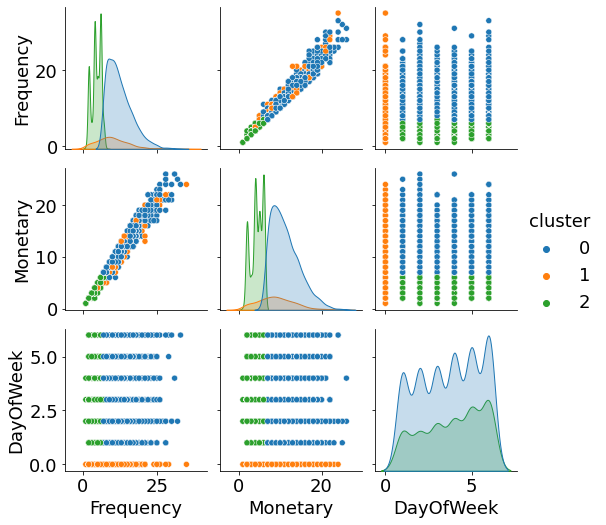

In [40]:
# Create the scatter plot with colors
sns.pairplot(model_data, hue="cluster", diag_kind="kde",palette= 'tab10');

#### This chart tells more:

- The customer who purchased on Monday (the first day of the week) significantly has similar traits, habits, and lifestyles. We can participate in interviews or surveys with them to understand what caused them to purchase on the first day of the week. Maybe Sunday is a day of rest. So they stay at home this day and consume things, which caused them to go to the market the second day for shopping. It's also possible that customers who purchase on Monday do so because they have more free time on that day, or because they are preparing for the week ahead. Understanding these underlying factors can help the store to tailor its marketing efforts and product offerings to better meet the needs of these customers. However, it's important to note that customers in this cluster may also be infrequent or one-time buyers, which could limit the potential for long-term engagement and loyalty. To address this, the store may need to implement retention strategies such as personalized offers, loyalty programs, or exceptional customer service to encourage these customers to continue doing business with the store.

- Customers who have low monetary and low-frequency values may be considered at risk of churning, which means they may stop doing business with the store in the future. This is because customers who have low spending habits and low engagement with the store may not see the value in continuing to do purchase with the store and may prefer to purchase from elsewhere. To better understand whether customers with low monetary and low-frequency values are at risk of churning, it may be helpful to examine additional factors, such as their engagement with the store's marketing campaigns or customer service interactions through interviews or surveys. There are several strategies that the store can use to increase their engagement and encourage them to continue doing business with the store:

    - Targeted promotions: Offer personalized promotions or discounts to customers who have low monetary and low frequency values. This can help to incentivize them to make a purchase and increase their engagement with the store.
 
    - Improve customer experience: Focus on providing exceptional customer service and a seamless customer experience to help build trust and loyalty with customers. This can encourage them to continue doing orders with the store, even if they have low monetary and low frequency values.

    - Increase brand awareness: Increase the store's visibility and brand awareness through advertising, social media, and other marketing channels. This can help to attract new customers and increase engagement with existing customers, including those with low monetary and low frequency values.

    - Loyalty programs: Consider implementing a loyalty program that incentivizes customers to make repeat purchases and increase their engagement with the store. This can help to build customer loyalty and increase their lifetime value to the store.

- Customers who have high frequency and high monetary values may be more likely to have developed a sense of loyalty to the store. This is because they have demonstrated a sustained interest in the store's offerings and have invested a significant amount of money and time into their relationship with the store. However, it's important to note that loyalty is not guaranteed and should not be taken for granted. Even customers who have reached the loyalty stage of the marketing funnel can be at risk of churning if they experience a negative experience with the store or if they perceive that they are not receiving sufficient value from their relationship with the store. To maintain customer loyalty, it's important for the store to continue to provide high-quality products or services, personalized experiences, and exceptional customer service. Additionally, offering rewards programs or other incentives can help to reinforce the customer's sense of loyalty and encourage them to continue doing business with the store.